# Clasificación binaria con redes neuronales, parte 2

En este taller su objetivo es modificar los hiperparámetros de una red neuronal para lograr solucionar un problema de clasificación binaria con una exactitud mayor o igual al 90% en los datos de prueba. Para esto, puede basarse en el taller anterior y sugerimos experimentar con los siguientes hiperparámetros:



*   Añadir o quitar neuronas en una capa.  
*   Añadir o quitar capas ocultas.
*   Experimentar con distintas funciones de activación. [Funciones de activación en PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-other)
*   Experimentar con distintas funciones de pérdida. [Funciones de pérdida en PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions)
*   Entrenar durante menos o más épocas.
*   Aumentar o disminuir la tasa de aprendizaje. [Optimizadores en PyTorch](https://pytorch.org/docs/stable/optim.html)
*   Entrenar con distintos optimizadores. [Optimizadores en PyTorch](https://pytorch.org/docs/stable/optim.html)
*   Visualizar las curvas de entrenamiento para inferir qué puede estar fallando/funcionando bien.
*   Modificar un hiperparámetro a la vez, entrear la red y ver qué efecto tuvo el cambio de este hiperparámetro durante el entrenamiento. Si cambia varios hiperparámetros a la vez, será más dificil identificar qué impacto tuvo este cambio durante el entrenamiento.
*   Llevar un registro de los cambios que ha hecho hasta el momento y qué impacto han tenido durante el entrenamiento.
*   No tenga miedo de experimentar ¡buena suerte!








In [1]:
#Importamos las librerias necesarias
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np

In [2]:
#En esta celda podemos verificar qué versión de PyTorch y Sklearn estamos utilizando 
print(f'torch: {torch.__version__}')
print(f'Sklearn: {sklearn.__version__}')

torch: 2.1.2+cu121
Sklearn: 1.3.2


In [3]:


#Una serie de funciones auxiliares utilizadas para visualizar nuestros resultados.

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):

    """
    Dibuja los límites de decisión del modelo al predecir en X en comparación con y.
    """
    # Pon todo en la CPU (funciona mejor con NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Configurar los límites de predicción y la cuadrícula
    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Crear características
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Realizar predicciones
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Comprobar si es multiclase o binario y ajustar los logits a las etiquetas de predicción
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # multiclase
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binario

    # Reformar predicciones y trazar
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap = plt.cm.RdYlBu, alpha = 0.6)
    plt.scatter(X[:, 0], X[:, 1], c = y, s = 35, cmap = plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)

    model.to(device)
    X, y = X.to(device), y.to(device)


# Calcular la exactitud
def accuracy_fn(y_true, y_pred):
    """Calcula la exactitud entre las etiquetas verdaderas y las predicciones.

    Args:
        y_true (torch.Tensor): Etiquetas verdaderas para las predicciones.
        y_pred (torch.Tensor): Predicciones a comparar con las etiquetas verdaderas.

    Devuelve:
        [torch.float]: Valor de exactitud entre y_true y y_pred, p. ej., 78,45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


# Función para trazar curvas de pérdida de un modelo
def plot_loss_curves(results):
    """Trazar las curvas de entrenamiento de un diccionario de resultados.

    Args:
        results (dict): diccionario que contiene listas de valores, p. ej.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    loss = np.array(torch.tensor(results["train_loss"]).cpu().numpy())
    test_loss = np.array(torch.tensor(results["test_loss"]).cpu().numpy())
    accuracy = np.array(torch.tensor(results["train_acc"]).cpu().numpy())
    test_accuracy = np.array(torch.tensor(results["test_acc"]).cpu().numpy())

    epochs = range(0,len(np.array(torch.tensor(results["train_loss"]).cpu().numpy()))*10,10)

    plt.figure(figsize = (15, 7))

    # Trazar la pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "Pérdida de entrenamiento")
    plt.plot(epochs, test_loss, label = "Pérdida de prueba")
    plt.title("Pérdida")
    plt.xlabel("Épocas")
    plt.legend()

    # Trazar la exactitud
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "Exactitud de entrenamiento")
    plt.plot(epochs, test_accuracy, label = "Exactitud de prueba")
    plt.title("Exactitud")
    plt.xlabel("Época")
    plt.legend()
    plt.show()

def set_seeds(seed: int = 0):
    """Establece las semillas aleatorias para operaciones en torch.

    Args:
        seed (int, opcional): Semilla aleatoria para establecer. Valor predeterminado: 42.
    """
    # Establece la semilla para operaciones generales en torch
    torch.manual_seed(seed)
    # Establece la semilla para operaciones en CUDA torch (las que ocurren en la GPU)
    torch.cuda.manual_seed(seed)
assert True==True


## 1.0 Generación y procesamiento de los datos

In [4]:
#Vamos a generar 1000 datos
n_samples=1000
#X, y = make_moons(n_samples=100, noise=0.13, random_state=42)
X,y=make_gaussian_quantiles(mean = None, cov = 10, n_samples = 1000, n_features = 2, n_classes = 2, shuffle = False, random_state = 0)

In [5]:
#Convertimos nuestros datos en tensores
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [6]:
#Esta función separa los datos en los conjuntos de entrenamiento y prueba. Escoge los conjuntos de forma aleatoria.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.2, #20% de nuestros datos serán
                                                   #de prueba y el otro 80% serán de entrenamiento
                                                   random_state = 0)

IMPORTANTE! Recuerde que entrenar una red neuronal profunda es una tarea costosa computacionalmente. Para acelerar nuestro proceso de entrenamiento debemos utilizar una GPU en vez de la CPU.

Las GPUs, o Unidades de Procesamiento Gráfico, desempeñan un papel crucial en la inteligencia artificial debido a su capacidad para realizar una gran cantidad de cálculos simultáneamente, lo que se conoce como procesamiento paralelo. Esta característica las hace ideales para tareas intensivas en cálculos, como el entrenamiento de redes neuronales en el aprendizaje profundo. A diferencia de las CPU tradicionales, que están diseñadas para realizar cálculos secuenciales, las GPUs están optimizadas para ejecutar múltiples tareas en paralelo, lo que acelera significativamente el proceso de entrenamiento de modelos de IA y reduce el tiempo requerido. Esta capacidad de procesamiento masivo las convierte en el corazón de la IA actual, permitiendo avances significativos en campos como el procesamiento de lenguaje natural, la visión por computadora y más.

En la siguiete celda podemos asegurarnos que estemos trabajando con una GPU. 

In [7]:
#Nos aseguramos de estar trabajando con la GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
def TrainNetwork(model_1,epochs,loss_fn,optimizer,X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,):
    #Fijamos una semilla aleatoria para que nuestros resultados sean reproducibles.
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    #Guardamos diferentes valores para luego graficarlos. Guardaremos las épocas
    #y la pérdida y exactitud de prueba y entrenamiento.
    epoch_count = []
    loss_values = []
    test_loss_values = []
    train_acc_values = []
    test_acc_values = []

    #Le decimos que haga los cálculos en la GPU.
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    #Iteramos en cada época.
    for epoch in range(epochs):
        #Le decimos al modelo que se ponga en 'modo de entrenamiento'.
        model_1.train()

        #2.Hacemos un paso forwarad.
        y_logits = model_1(X_train).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))


        #3. Calculamos la pérdida y la exactitud de nuestro modelo para los datos para los que hicimos
        #el paso forward en el paso 2.
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

        #Esta función 'reinicia' los gradientes. Se utiliza cuando estamos entrenando por batches de datos y tenemos
        #memoria limitada. PyTorch per defecto acumula los gradientes de un batch y cuando pasamos de un batch a otro,
        #debemos reiniciar el gradiente.
        optimizer.zero_grad()

        #4. Utilizamos el algoritmo de retropropagación para estimar el gradiente de la pérdida.
        loss.backward()

        #5. Utilizamos el algoritmo de descenso del gradiente estocástico para actualizar los pesos de nuestra
        #red.
        optimizer.step()

        #6. Probamos el modelo con los pesos actualizados en el conjunto de prueba. Guardamos estos valores para irlos
        #graficando y poder evaluar si nuestra red está aprendiendo.

        #Le decimos al modelo que se ponga en 'modo de evaluación'.
        model_1.eval()
        with torch.inference_mode():

            test_logits = model_1(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))
            #Calculamos la pérdida y la exactitud en el conjunto de prueba
            test_loss = loss_fn(test_pred, y_test)
            test_acc = accuracy_fn(y_true = y_test,
                          y_pred = test_pred)


        #Vamos a guardar los resultados cada 10 épocas para luego graficarlos.
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            loss_values.append(loss)
            test_loss_values.append(test_loss)
            train_acc_values.append(acc)
            test_acc_values.append(test_acc)
    #Guardamos los resultados del entrenamiento para luego graficarlos.
    results = {"train_loss": loss_values,
              "train_acc": train_acc_values,
              "test_loss": test_loss_values,
              "test_acc":test_acc_values}
    return results

Recuerde que es deseable entrenar con una GPU si queremos acelerar nuestro entrenamiento.

In [9]:
#Esta función conocida como accuracy o exactitud nos dará una medida de qué tan bien está clasificando nuestra red.
#Esta métrica es simplemente el porcentaje de clasificaciones correctas que ha hecho el modelo sobre el total de predicciones
#realizadas.
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

## 2.0 Arquitectura de la red e hiperparámetros de entrenamiento.

En la siguiente celda podrá modificar la arquitectura de la red. En esta celda podrá modificar la cantidad de neuronas y capas ocultas. También podrá modificar las funciones de activación de la red.

In [10]:
#Crearemos un segundo modelo que instancia la clase nn de PyTorch (nn de Neural Network)
class ClassifierModelV2(nn.Module):
    def __init__(self):
        #Inicializamos la clase
        super().__init__()

        # Inicialemente tenemos 3 capas donde todas las neuronas tienen función de activación lineal (nn.Linear), las
        #Puede editar en este espacio la arquitectura de la red.
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)


        #Definimos la función de activación no lineal que vamos a utilizar. (ReLU)
        #Acá puede experimentar con otras funciones de activación, por ejemplo: nn.Sigmoid, nn.Tanh, etc. Revise la documentación.
        self.relu = nn.ReLU()



    #En la función forward vamos a añadir la función de activación no-lineal para las capas ocultas.
    #Note que le aplicamos la función self.relu unicamente a la salida de primera y segunda capa, pues estas
    #son nuestras únicas capas ocultas.
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

Tras modificar la arquitectura, deberemos crear una instancia de nuestro modelo.

In [11]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
model_1 = ClassifierModelV2().to(device)

En la siguiente celda, podrá editar la función de pérdida y el optimizador que quiera utilizar. Recuerde revisar la documentación de torch.nn.

In [12]:
def LossAndOptim():
    
    #Acá, puede cambiar la funciíon de perdida por cualquiera que desee.
    #En este taller inicializamos con la función de pérdida L1.
    #Puede probar con nn.BCEWithLogitsLoss(), nn.L1Loss(), etc.
    loss_fn = nn.BCEWithLogitsLoss() 

    #Acá, puede cambiar el optimizador para el entrenamiento.
    #En este taller inicializamos con el optimizador de descenso del gradiente estocástico
    #y con una tasa de aprendizaje de 0.07.
    optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001, weight_decay=1e-4)
    
    return loss_fn, optimizer

En la siguiente celda, podrá editar el número de épocas durante las cuales quiera entrenar a la red.

In [13]:
#Por cuántas épocas queremos entrenar.
epochs = 300

## 3.0 Entrenamiento y resultados.

Puede ejecutar las siguientes celdas para entrenar su red y observar las curvas de entrenamiento y la frontera de decisión.

In [14]:
#La función TrainNetwork entrena la red utilizando todos los hiperparámetros y la arquitectura que
#usted diseñó.

#Reiniciamos el modelo con los nuevos cambios
torch.manual_seed(0)
torch.cuda.manual_seed(0)
model_1 = ClassifierModelV2().to(device)

#Le decimos al modelo qué función de pérdida y optimizador usar.
loss_fn,optimizer = LossAndOptim()

TrainingCurves = TrainNetwork(model_1,epochs,loss_fn,optimizer)

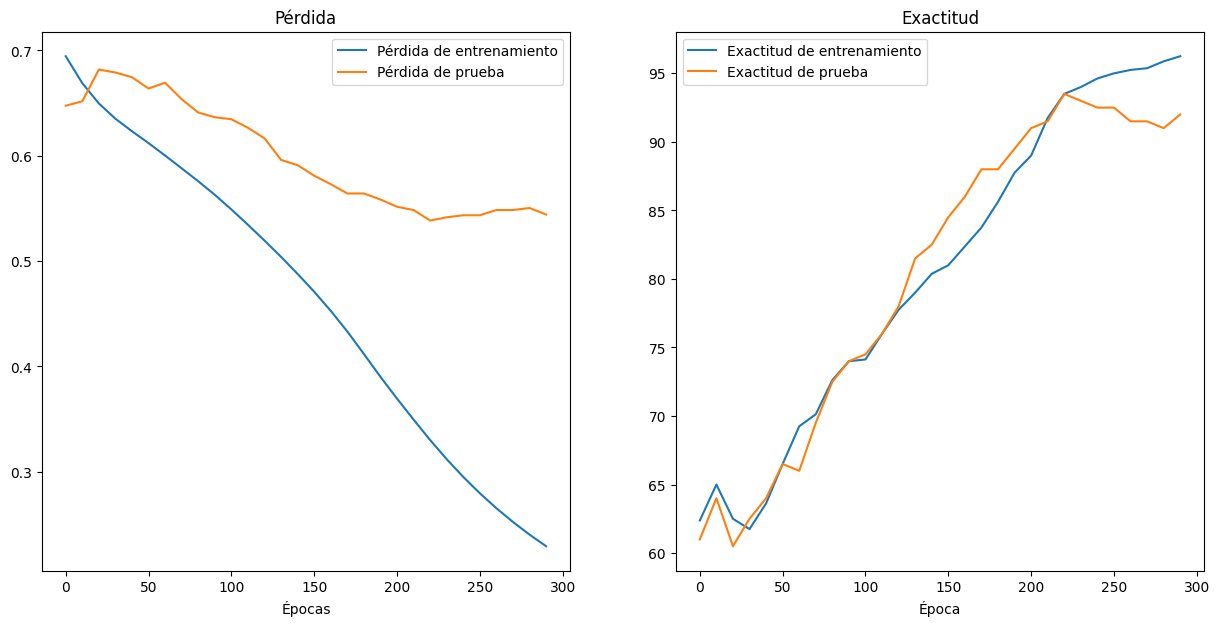

In [15]:
plot_loss_curves(TrainingCurves)

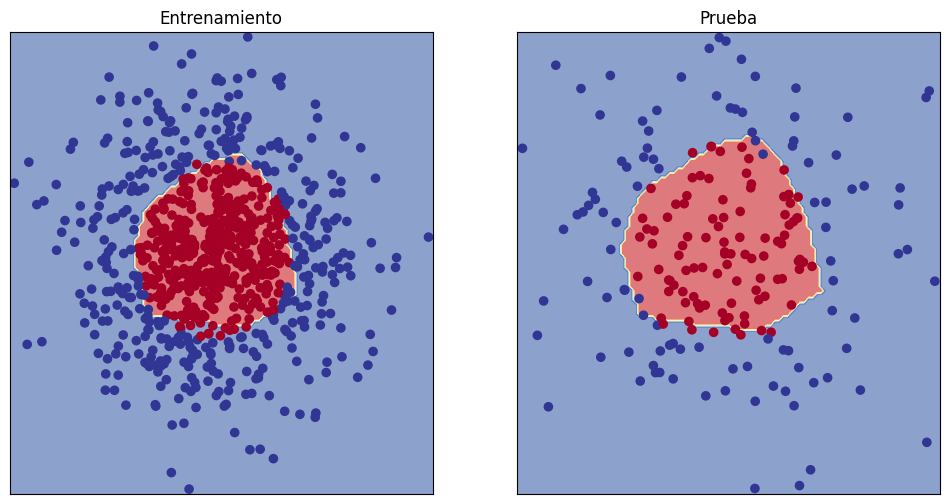

In [16]:
#Plot decision boundaries
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title('Entrenamiento')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Prueba')
plot_decision_boundary(model_1,X_test, y_test)
plt.show()

**IMPORTANTE** Antes de enviar su laboratorio, puede asegurarse de que su red pasa el test ejecutando la siguiente celda. 

In [17]:
def CheckAccuracy(model,loss_fn,X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):

    try:
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        #2.Hacemos un paso forwarad.
        y_logits = model(X_train).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))


        #3. Calculamos la pérdida y la exactitud de nuestro modelo para los datos para los que hicimos
        #el paso forward en el paso 2.
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)
        model.eval()
    except:
        print('Debe ingresar un modelo válido de PyTorch')
    else:
        with torch.inference_mode():
            test_logits = model(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))
            #Calculamos la pérdida y la exactitud en el conjunto de prueba
            test_acc = accuracy_fn(y_true = y_test,
                                   y_pred = test_pred)
            if test_acc <= 89:
                print(f'Su modelo no superó una exactitud mayor o igual al 90% en el conjunto de prueba. Su modelo obtuvo una exactitud del {test_acc}%. Esto puede suceder por varias razones: \n 1. Una tasa de aprendizaje muy alta o muy baja. \n 2. Hay que entrenar durante más épocas. \n 3. Su modelo puede ser más complejo de lo necesario y está haciendo overfitting en los datos de entrenamiento. \n 4. Su modelo no es lo suficientemente complejo y no tiene la expresividad para trazar la frontera de decisión. \n 5. La función de pérdida que escogió no está diseñada para resolver un problema de clasificación binaria. \n \n Revise cuidadosamente las curvas de entrenamiento de su modelo para hacer los ajustes necesarios para mejorar el desempeño de su red.' )
            else:
                print(f'Felicidades! Su red neuronal clasifica los datos de prueba con una exactitud de {test_acc}%. ')

        return test_acc > 89

    finally:
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        X_test = X_test.to(device)
        y_test = y_test.to(device)


loss_fn,optimizer = LossAndOptim()
CheckAccuracy(model_1,loss_fn)

Felicidades! Su red neuronal clasifica los datos de prueba con una exactitud de 92.5%. 


True